# Clustering and module scores using Seurat

In [6]:
#load R libraries
library("tidyverse")
library("Matrix")
library("Seurat")
library("sctransform")
library("RColorBrewer")
library("cluster", quietly = TRUE)

# load matrices from CellRanger output

In [38]:
#Sample information can be found in Supplementary Table 10

#####################################################################
#60T control

#read sparse matrix
matrix_60_ctrl <- readMM(file = "MRT_data/MRT_60T_CTRL/matrix.mtx")

#read gene names and cell identities
cells_60_ctrl <- read.delim(file = "MRT_data/MRT_60T_CTRL/barcodes.txt", sep = "\t", header = FALSE, col.names = "barcodes")
genes_60_ctrl <- read.delim(file = "MRT_data/MRT_60T_CTRL/genes.txt", sep = "\t", header = FALSE, col.names = c("ENSEMBL", "gene"))

#add gene names and cell identities
colnames(matrix_60_ctrl) <- paste0(cells_60_ctrl$barcodes, "-CTRL60")
rownames(matrix_60_ctrl) <- genes_60_ctrl$gene

#####################################################################
#60T SMARCB1+

#read sparse matrix
matrix_60_smb <- readMM(file = "MRT_data/MRT_60T_SMB/matrix.mtx")

#read gene names and cell identities
cells_60_smb <- read.delim(file = "MRT_data/MRT_60T_SMB/barcodes.txt", sep = "\t", header = FALSE, col.names = "barcodes")
genes_60_smb <- read.delim(file = "MRT_data/MRT_60T_SMB/genes.txt", sep = "\t", header = FALSE, col.names = c("ENSEMBL", "gene"))

#add gene names and cell identities
colnames(matrix_60_smb) <- paste0(cells_60_smb$barcodes, "-SMB60")
rownames(matrix_60_smb) <- genes_60_smb$gene

#####################################################################
#Patient lines 78T and 103T were mixed pre-loading
#First, we load the mixed samples
#Demultiplexing was done using patient genotype data (see other notebook)

#78T and 103T mix control

#read sparse matrix
matrix_78_103_ctrl <- readMM(file = "MRT_data/MRT_78and103_CTRL/matrix.mtx")

#read gene names and cell identities
cells_78_103_ctrl <- read.delim(file = "MRT_data/MRT_78and103_CTRL/barcodes.txt", sep = "\t", header = FALSE, col.names = "barcodes")
genes_78_103_ctrl <- read.delim(file = "MRT_data/MRT_78and103_CTRL/features.txt", sep = "\t", header = FALSE, col.names = c("ENSEMBL", "gene", "exp"))

#add gene names and cell identities
colnames(matrix_78_103_ctrl) <- cells_78_103_ctrl$barcodes
rownames(matrix_78_103_ctrl) <- genes_78_103_ctrl$gene

#####################################################################
#78T and 103T mix SMARCB1+

#read sparse matrix
matrix_78_103_smb <- readMM(file = "MRT_data/MRT_78and103_SMB/matrix.mtx")

#read gene names and cell identities
cells_78_103_smb <- read.delim(file = "MRT_data/MRT_78and103_SMB/barcodes.txt", sep = "\t", header = FALSE, col.names = "barcodes")
genes_78_103_smb <- read.delim(file = "MRT_data/MRT_78and103_SMB/features.txt", sep = "\t", header = FALSE, col.names = c("ENSEMBL", "gene", "exp"))

#add gene names and cell identities
colnames(matrix_78_103_smb) <- cells_78_103_smb$barcodes
rownames(matrix_78_103_smb) <- genes_78_103_smb$gene

# Create Seurat objects

In [40]:
#create seurat object
#combine control and SMARCB1 samples
seurat_60 <- CreateSeuratObject(cbind(matrix_60_ctrl, matrix_60_smb))
seurat_78_103 <- CreateSeuratObject(cbind(matrix_78_103_ctrl, matrix_78_103_smb))

Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”
Warning message:
“Non-unique features (rownames) present in the input matrix, making unique”
Warning message:
“Non-unique cell names (colnames) present in the input matrix, making unique”
Warning message:
“Feature names cannot have underscores ('_'), replacing with dashes ('-')”


In [29]:
#read metadata of filtered cells (see other Jupyter notebook for details on filtering)
metadata_single_cells <- read.delim(file = "MRT_data/metadata_filtered_single_cells.txt", sep = "\t", row.names = 11)

In [43]:
#subset for filtered cells
#seperate 78T and 103T here
seurat_60 <- subset(seurat_60, cells = row.names(metadata_single_cells)[metadata_single_cells$patient_line == "60T"])
seurat_78 <- subset(seurat_78_103, cells = gsub(row.names(metadata_single_cells)[metadata_single_cells$patient_line == "78T"], pattern = "-1-.*", replacement = "-1"))
seurat_103 <- subset(seurat_78_103, cells = gsub(row.names(metadata_single_cells)[metadata_single_cells$patient_line == "103T"], pattern = "-1-.*", replacement = "-1"))

In [48]:
#rename cell identities to annotate patient line 78T and 103T in cell id
seurat_78 <- RenameCells(seurat_78, new.names = row.names(metadata_single_cells)[metadata_single_cells$patient_line == "78T"])
seurat_103 <- RenameCells(seurat_103, new.names = row.names(metadata_single_cells)[metadata_single_cells$patient_line == "103T"])

In [49]:
#Add metadata
seurat_60 <- AddMetaData(seurat_60, metadata = metadata_single_cells[,c("sample", "patient_line", "smarcb1")])
seurat_78 <- AddMetaData(seurat_78, metadata = metadata_single_cells[,c("sample", "patient_line", "smarcb1")])
seurat_103 <- AddMetaData(seurat_103, metadata = metadata_single_cells[,c("sample", "patient_line", "smarcb1")])

# Analysis of cells from all patient lines combined

This applies to Fig. 2f, g, Supplementary Fig. 3d, e

In [50]:
#combine seurat objects
seurat_mrt <- merge(seurat_60, y = c(seurat_78, seurat_103))

In [53]:
#calculate percentage of mitochondrial genes to use for normalization
seurat_mrt[["percent.mt"]] <- PercentageFeatureSet(object = seurat_mrt, pattern = "^MT-")

#normalize and regress out percentage of mitochondrial genes
#suppress warning: iteration limit reached
seurat_mrt <- suppressWarnings(SCTransform(seurat_mrt, vars.to.regress = c("percent.mt"), return.only.var.genes = FALSE))

#determine cell cycle phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
seurat_mrt <- CellCycleScoring(object = seurat_mrt, s.features = s.genes, g2m.features = g2m.genes)

#renormalize to regress out cell cycle effects
#suppress warning: iteration limit reached
seurat_mrt <- suppressWarnings(SCTransform(seurat_mrt, vars.to.regress = c("percent.mt", "S.Score", "G2M.Score"), return.only.var.genes = FALSE))

Calculating cell attributes for input UMI matrix

Variance stabilizing transformation of count matrix of size 22229 by 16132

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 16132 cells



  |======================================================================| 100%


Found 9 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22229 genes



  |======================================================================| 100%


Computing corrected count matrix for 22229 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 10.16103 mins

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Regressing out percent.mt

Centering data matrix

Set default assay to SCT

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Calculating cell attributes for input UMI matrix

Variance stabilizing transformation of count matrix of size 22229 by 16132

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 16132 cells



  |======================================================================| 100%


Found 9 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 22229 genes



  |======================================================================| 100%


Computing corrected count matrix for 22229 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 10.44896 mins

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, S.Score, G2M.Score

Centering data matrix

Set default assay to SCT



PC_ 1 
Positive:  TMSB4X, IFI27, G0S2, TMSB10, KRT18, MGP, RPL41, RPS29, RPL13A, RPS2 
	   OCIAD2, STC1, SVIP, CCL2, RPL23A, RPL21, RPS17, S100A4, IGFL3, RPL27A 
	   IFITM3, TRAC, SLC25A6, FTL, SCN9A, ASS1, MIR4435-2HG, ARHGAP15, SPTSSA, HMGA1 
Negative:  S100A6, MTRNR2L12, DLK1, NEAT1, MTRNR2L1, MEG3, DST, PEG10, MALAT1, MTRNR2L8 
	   RBP1, IGFBP2, IGFN1, SERPINE2, ID3, CPE, TIMP3, PCSK1N, KCNQ1OT1, SPARC 
	   FBN1, S100A16, SOX4, APOE, CDKN1C, SMARCB1, TBX3, TTN, IGFBP5, GNAS 
PC_ 2 
Positive:  NEAT1, COL3A1, TIMP3, LUM, ARHGAP15, IGFN1, XIST, BTG1, MGP, IGFBP2 
	   MTRNR2L8, PXDN, DCN, NR2F1, LIFR, THBS2, ADD3, MALAT1, SFRP1, PRRX1 
	   IGFBP5, FGF7, FLRT2, IFITM2, EFEMP1, TMEM178A, COL1A1, ZEB2, ZFHX4, TAGLN 
Negative:  DLK1, MTRNR2L1, S100A6, ID3, LHX1, SAT1, RBP1, VGF, APOE, TUBA1A 
	   S100A13, CPE, TBX3, PEG10, SOX2, NEFL, NEFM, TTN, PON2, PNOC 
	   WIF1, RPS4Y1, DKK1, STAR, PRKAR2B, DNAJC12, SPINT2, PCSK1N, MTUS1, NQO2 
PC_ 3 
Positive:  SFRP1, PRRX1, S100A6, SMPX, TIMP3, FGF5

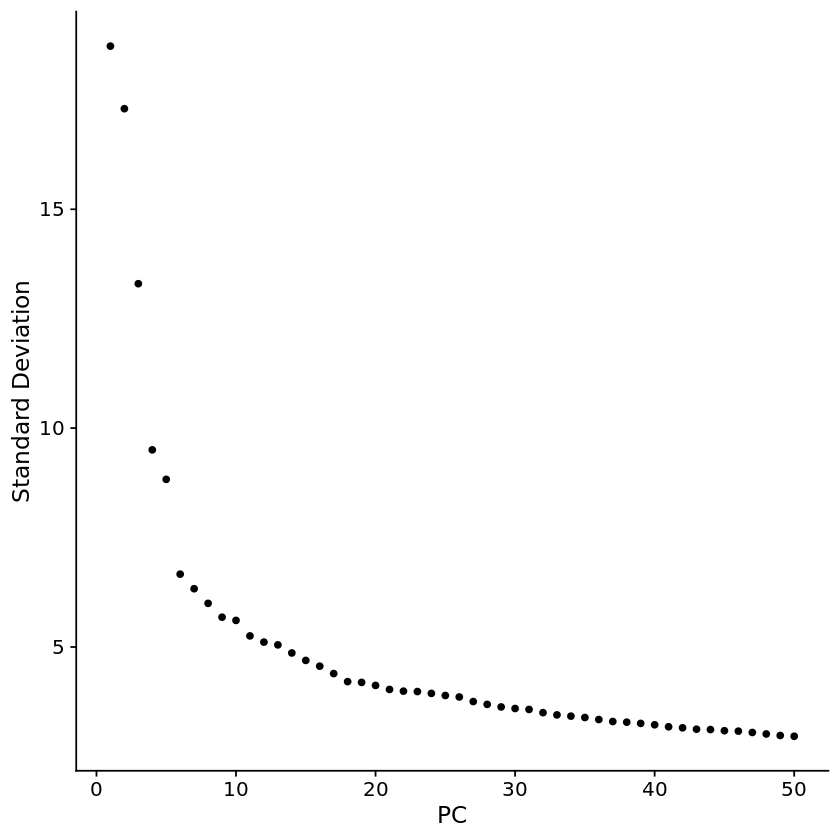

In [54]:
#run PCA analysis using variable features
seurat_mrt <- RunPCA(object = seurat_mrt)

#Identify significant principal components
#Inclusion of principal components was based on a scree plot  by placing the cutoff at the elbow of the curve
ElbowPlot(object = seurat_mrt, ndims = 50)

In [56]:
#Cutoff was determined at 18 PCs
#Generate UMAP
seurat_mrt <- RunUMAP(seurat_mrt, dims = 1:18)

14:25:44 UMAP embedding parameters a = 0.9922 b = 1.112

14:25:44 Read 16132 rows and found 18 numeric columns

14:25:44 Using Annoy for neighbor search, n_neighbors = 30

14:25:44 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

14:25:50 Writing NN index file to temp file /scratch/7478184/RtmpA4jZOT/file14493c33490

14:25:50 Searching Annoy index using 1 thread, search_k = 3000

14:25:57 Annoy recall = 100%

14:25:57 Commencing smooth kNN distance calibration using 1 thread

14:25:59 Initializing from normalized Laplacian + noise

14:26:00 Commencing optimization for 200 epochs, with 656096 positive edges

14:26:11 Optimization finished



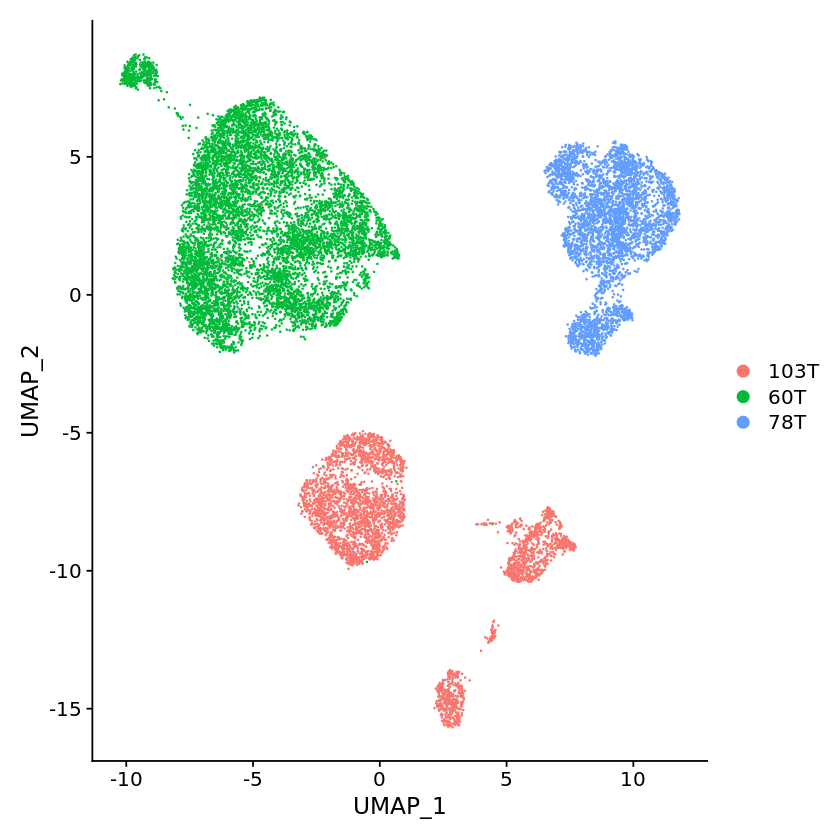

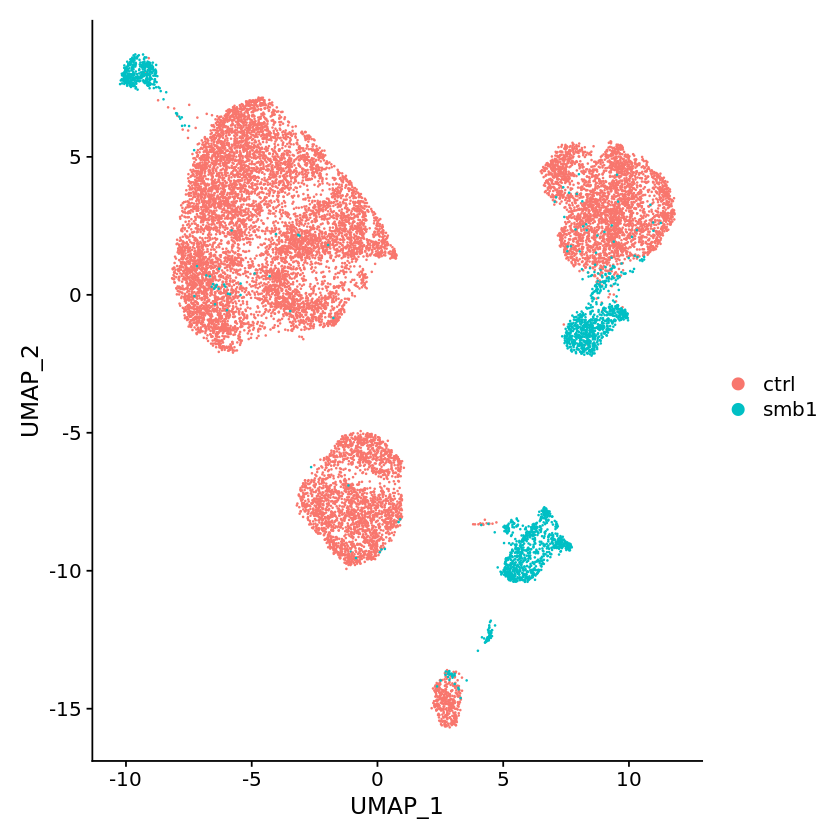

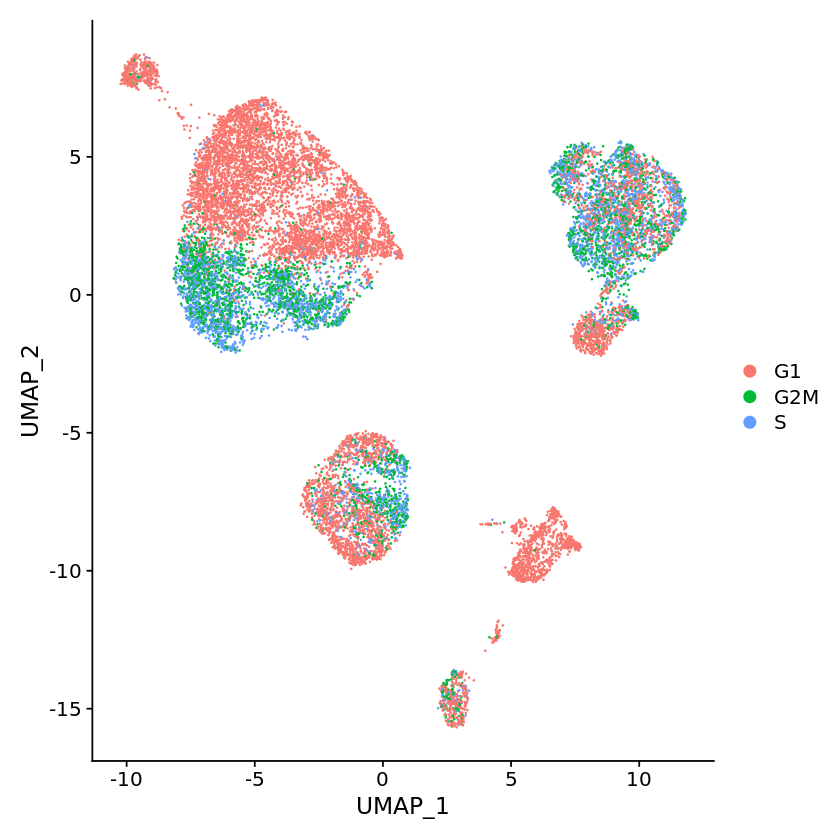

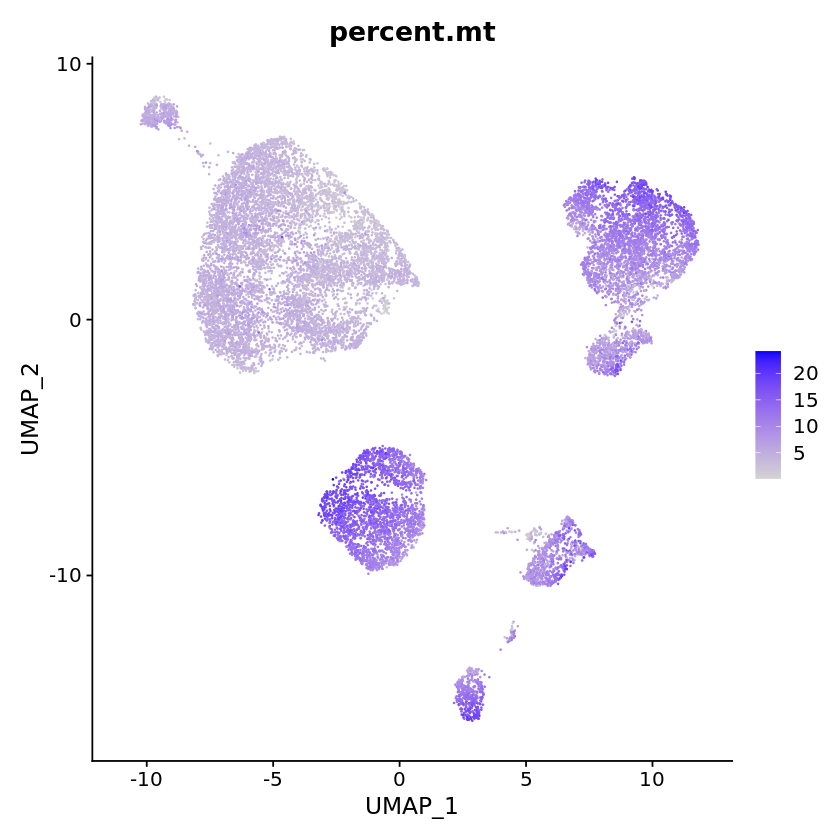

In [57]:
#Plot umaps, to show seperation of cells, grouped by patient line, smarcb1
DimPlot(seurat_mrt, reduction = "umap", group.by = "patient_line")
DimPlot(seurat_mrt, reduction = "umap", group.by = "smarcb1")

#QC: plot umaps, to show seperation of cells, grouped by cell cycle phase and mitrochondrial percentage
DimPlot(seurat_mrt, reduction = "umap", group.by = "Phase")
FeaturePlot(seurat_mrt, reduction = "umap", features = "percent.mt")

# Calculate module scores for combined analysis

In [62]:
#Neural crest branch specific gene-sets include marker genes that separate sensory and autonomic/mesenchymal branches
#further specifying late genes (upregulated in differentiated cells) and early genes (upregulated in progenitor and differentiated cells)
#Mouse genes without human orthologue were excluded

#load table with mouse human orthologues generated using biomart
mouse_orthologues <- read.delim(file = "MRT_data/Module_scores/m_orthologues_symbol.txt", sep = "\t", col.names = c("mouse_id", "mouse_name", "human_id", "human_name"))

#load table with autonomic/mesenchymal or sensory branch differentiation genes and only include orthologues
#Table was downloaded from http://pklab.med.harvard.edu/ruslan/neural.crest.html
me_aut_sen_genes <- read.csv(file = "MRT_data/Module_scores/bifur_sensory_auto.csv", col.names = c("mouse_name", "branch", "type")) %>%
  merge(mouse_orthologues, ., by = "mouse_name", all = FALSE)

me_aut_genes_early <- filter(aut_sen_genes, branch == "autonomic", type == "early")$human_name
me_aut_genes_late <- filter(aut_sen_genes, branch == "autonomic", type == "late")$human_name
sen_genes_early <- filter(aut_sen_genes, branch == "sensory", type == "early")$human_name
sen_genes_late <- filter(aut_sen_genes, branch == "sensory", type == "late")$human_name

In [72]:
#Generate module scores for each cell
#Module scores are generated by averaging gene expression levels per set of genes
seurat_mrt <- AddModuleScore(seurat_mrt, features = list(me_aut_genes_early), name = "aut_mes_early")
seurat_mrt <- AddModuleScore(seurat_mrt, features = list(me_aut_genes_late), name = "aut_mes_late")
seurat_mrt <- AddModuleScore(seurat_mrt, features = list(sen_genes_early), name = "sen_early")
seurat_mrt <- AddModuleScore(seurat_mrt, features = list(sen_genes_late), name = "sen_late")


Warning message:
“The following features are not present in the object: NIBAN2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CCL15-CCL14, CCL23, PHOX2B, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: AC008012.1, AC020907.6, NKX1-2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: AC090227.2, NEUROD4, NEUROG1, ONECUT1, PPP1R17, AC092143.1, not searching for symbol synonyms”


# Seperate analysis for each patient line: 60T

seperate analysis applies to Fig. 2c, Supplementary Fig. 4b, 5a-f

In [75]:
#calculate percentage of mitochondrial genes to use for normalization
seurat_60[["percent.mt"]] <- PercentageFeatureSet(object = seurat_60, pattern = "^MT-")

#normalize and regress out percentage of mitochondrial genes
#suppress warning: iteration limit reached
seurat_60 <- suppressWarnings(SCTransform(seurat_60, vars.to.regress = c("percent.mt"), return.only.var.genes = FALSE))

#determine cell cycle phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
seurat_60 <- CellCycleScoring(object = seurat_60, s.features = s.genes, g2m.features = g2m.genes)

#renormalize to regress out cell cycle effects
#suppress warning: iteration limit reached
seurat_60 <- suppressWarnings(SCTransform(seurat_60, vars.to.regress = c("percent.mt", "S.Score", "G2M.Score"), return.only.var.genes = FALSE))

Calculating cell attributes for input UMI matrix

Variance stabilizing transformation of count matrix of size 18028 by 8484

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 8484 cells



  |======================================================================| 100%


Found 5 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18028 genes



  |======================================================================| 100%


Computing corrected count matrix for 18028 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 5.571515 mins

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Regressing out percent.mt

Centering data matrix

Set default assay to SCT

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Calculating cell attributes for input UMI matrix

Variance stabilizing transformation of count matrix of size 18028 by 8484

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 8484 cells



  |======================================================================| 100%


Found 5 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18028 genes



  |======================================================================| 100%


Computing corrected count matrix for 18028 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 5.506919 mins

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, S.Score, G2M.Score

Centering data matrix

Set default assay to SCT



PC_ 1 
Positive:  CCK, MALAT1, RPL17, SMARCB1, MEST, C12orf75, SDC4, SLC12A2, AC090498.1, ADD3 
	   FSTL1, MMP2, ARHGAP29, RBP1, SAT1, CTHRC1, OLFML3, NBEAL1, RPL36A, CST1 
	   CD82, SOX4, RGS16, PXDN, H3F3B, SERPINE2, MIF, IGFBP2, PLCG2, ITGA6 
Negative:  FTL, RPS12, RPL27A, RPS18, RPS2, RPL13A, STC1, CDC42EP5, RPL28, RPL22L1 
	   TUBA1B, RPS19, CSTB, LINC01265, IGFL3, IFI27, VIM, H2AFJ, NAP1L1, CCDC34 
	   RPLP1, ITGA10, S100A7, SVIP, TNNT1, GAPDH, RPL3, TMSB10, SPTSSA, PLP1 
PC_ 2 
Positive:  MEST, EEF1A1, RPL3, RPL7, RPS18, MGP, NRN1, RPL13A, VIM, TIMP3 
	   RPS2, RPL26, SORBS2, RPL10, RPS24, COL1A1, MALAT1, RPS19, RPS27, MEG3 
	   HMGA2, ACTG1, NPM1, SFRP1, RPS12, RGS3, RPL27A, ENC1, RPL36A, RPL21 
Negative:  IFI27, S100A4, CSTB, G0S2, S100A10, SVIP, MT2A, S100A11, TMSB4X, STC1 
	   FTL, TMSB10, SH3BGRL3, ISG15, OCIAD2, S100A9, PHLDA2, PFN1, AP2S1, H2AFZ 
	   TM4SF1, CCL2, KRT18, S100A6, FKBP1A, IFI6, TXNRD1, TXN, S100A13, SPTSSA 
PC_ 3 
Positive:  CCL2, MEG3, CAMK2N1, PDLIM1, COL

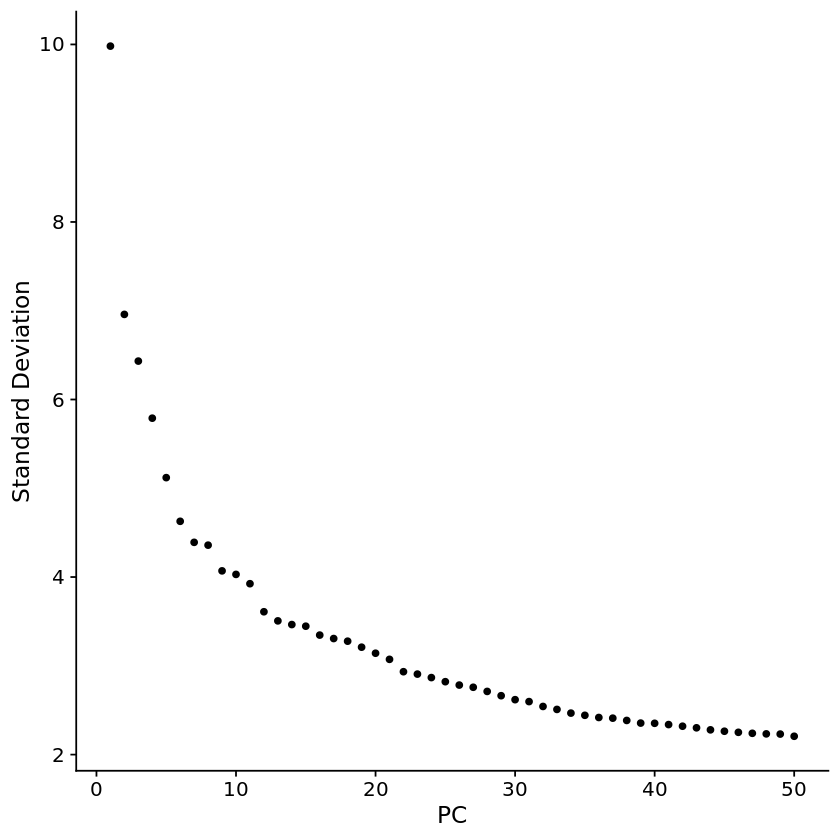

In [76]:
#run PCA analysis using variable features
seurat_60 <- RunPCA(object = seurat_60)

#Identify significant principal components
#Inclusion of principal components was based on a scree plot  by placing the cutoff at the elbow of the curve
ElbowPlot(object = seurat_60, ndims = 50)

In [93]:
#Cutoff was determined at 15 PCs
#Generate UMAP
seurat_60 <- RunUMAP(seurat_60, dims = 1:15)

15:29:05 UMAP embedding parameters a = 0.9922 b = 1.112

15:29:05 Read 8484 rows and found 15 numeric columns

15:29:05 Using Annoy for neighbor search, n_neighbors = 30

15:29:05 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

15:29:08 Writing NN index file to temp file /scratch/7478184/RtmpA4jZOT/file1449501460a2

15:29:08 Searching Annoy index using 1 thread, search_k = 3000

15:29:12 Annoy recall = 100%

15:29:12 Commencing smooth kNN distance calibration using 1 thread

15:29:13 Initializing from normalized Laplacian + noise

15:29:13 Commencing optimization for 500 epochs, with 336722 positive edges

15:29:27 Optimization finished



Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8484
Number of edges: 264810

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9596
Number of communities: 4
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8484
Number of edges: 264810

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9379
Number of communities: 4
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8484
Number of edges: 264810

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9171
Number of communities: 5
Elapsed time: 1 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8484
Number of edges: 264810

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8968
Number of communities: 6
Elapsed time: 1 seconds
Modularity Optimizer

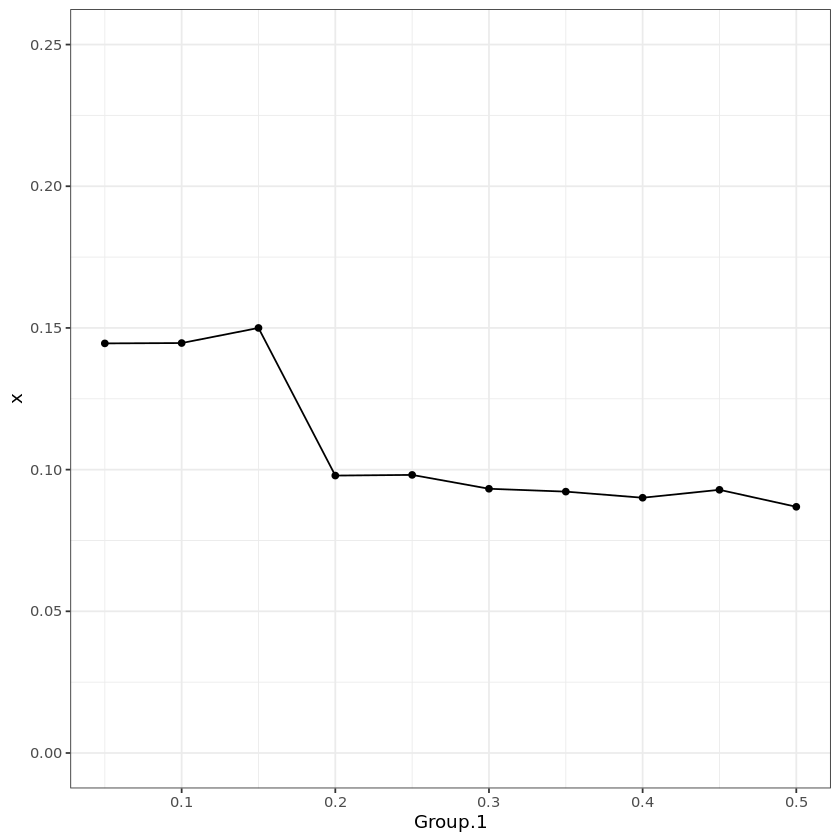

In [80]:
#For clustering of single cells, determine optimal clustering resolution by calculating average silhouette width
seurat_subset <- seurat_60

seurat_subset <- FindNeighbors(object = seurat_subset, dims = 1:15)

#generate table with silhouette widths
res_clusters <- c(0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5)
sil_width <- data.frame(res = c(), sil = c())

for(r in res_clusters){
  seurat_subset <- FindClusters(object = seurat_subset, resolution = r)
  dist.matrix <- dist(x = Embeddings(seurat_subset)[,1:15])
  clusters <- seurat_subset$seurat_clusters
  sil <- silhouette(x = as.numeric(x = as.factor(x = clusters)), dist = dist.matrix)
  seurat_subset$sil <- sil[,3]
  sil_width <- rbind(sil_width, data.frame(res = rep(r, nrow(seurat_subset@meta.data)), sil = seurat_subset$sil))
}

#calculate average silhouette width
sil_width_avg <- aggregate(sil_width$sil, by = list(sil_width$res), FUN = "mean")

#plot clustering resolution vs average silhouette width
plot_sil <- ggplot(sil_width_avg, aes(x = Group.1, y = x))+
  geom_point()+
  geom_line()+
  ylim(0,0.25)+
  theme_bw()
plot_sil

In [82]:
#Optimal clustering resolution was determined at 0.15
seurat_60 <- FindNeighbors(object = seurat_60, dims = 1:15)
seurat_60 <- FindClusters(object = seurat_60, resolution = 0.15)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 8484
Number of edges: 264810

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9171
Number of communities: 5
Elapsed time: 1 seconds


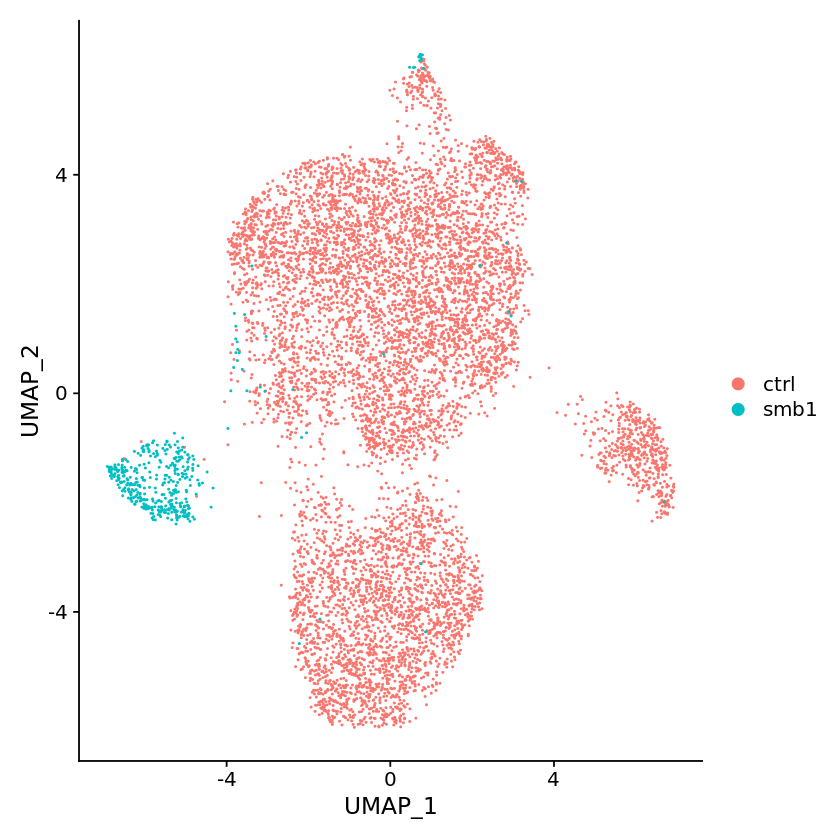

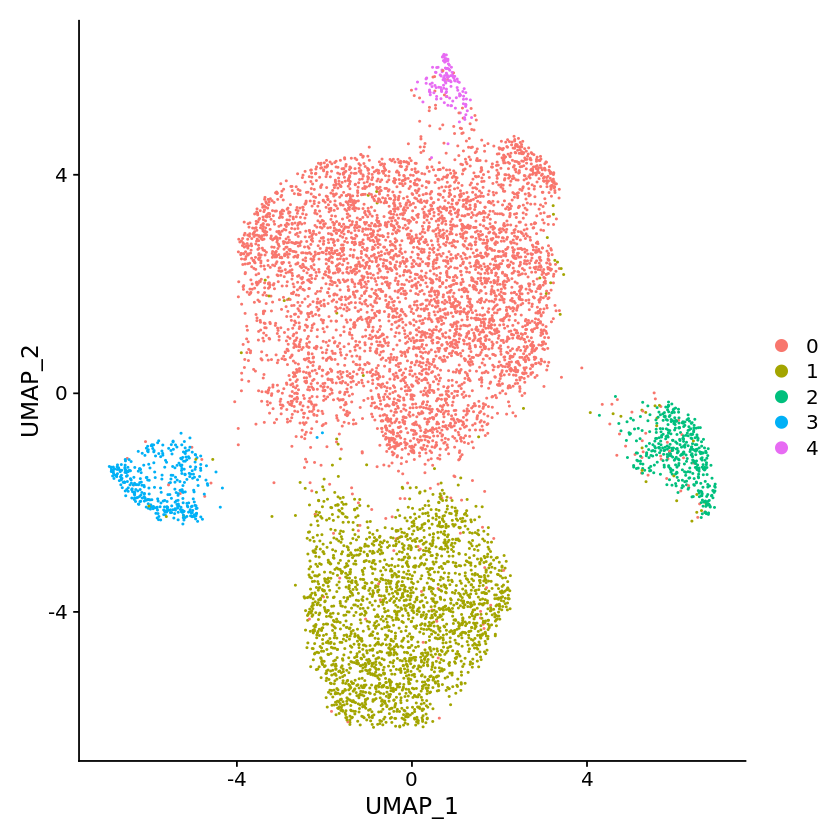

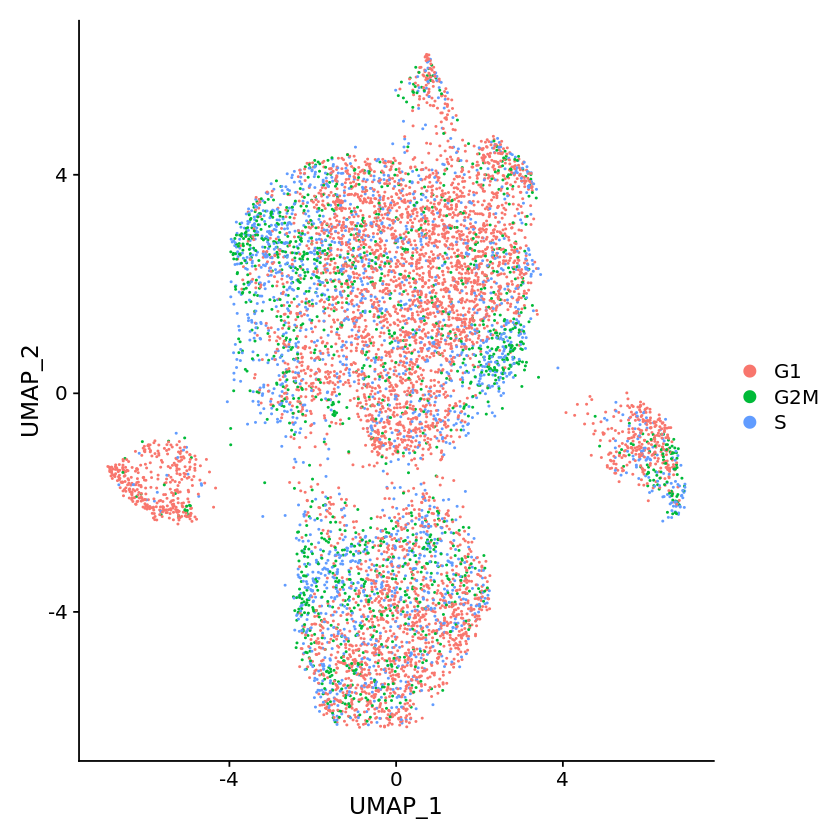

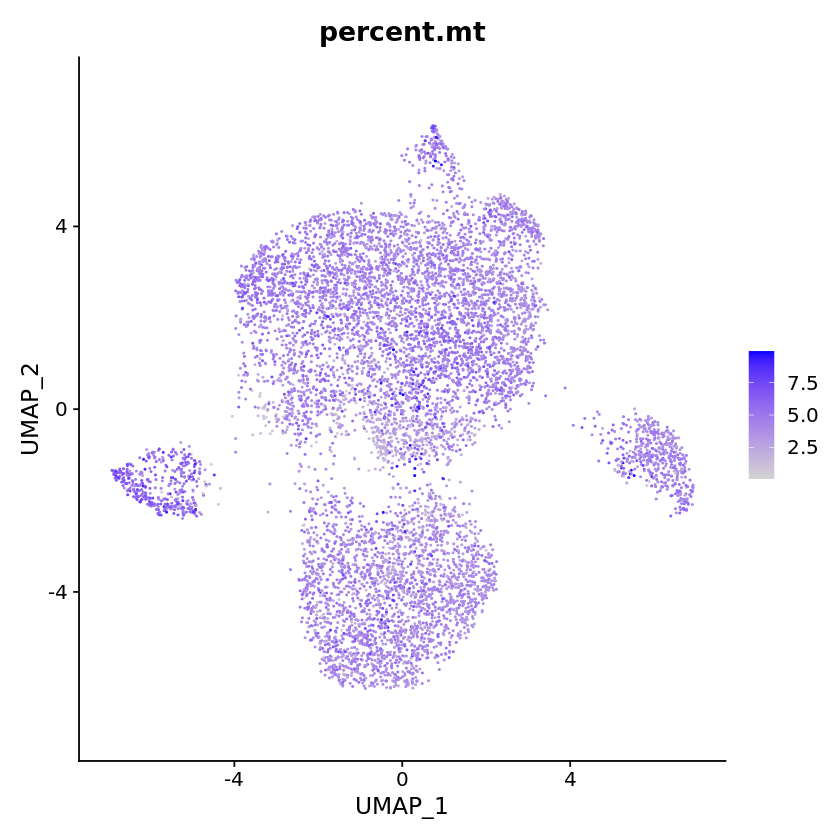

In [84]:
#Plot umaps, to show seperation of cells, grouped by smarcb1 and clusters
DimPlot(seurat_60, reduction = "umap", group.by = "smarcb1")
DimPlot(seurat_60, reduction = "umap", group.by = "seurat_clusters")

#QC: plot umaps, to show seperation of cells, grouped by cell cycle phase and mitrochondrial percentage
DimPlot(seurat_60, reduction = "umap", group.by = "Phase")
FeaturePlot(seurat_60, reduction = "umap", features = "percent.mt")

In [85]:
#Generate module scores for each cell
#Module scores are generated by averaging gene expression levels per set of genes
seurat_60 <- AddModuleScore(seurat_60, features = list(me_aut_genes_early), name = "aut_mes_early")
seurat_60 <- AddModuleScore(seurat_60, features = list(me_aut_genes_late), name = "aut_mes_late")
seurat_60 <- AddModuleScore(seurat_60, features = list(sen_genes_early), name = "sen_early")
seurat_60 <- AddModuleScore(seurat_60, features = list(sen_genes_late), name = "sen_late")

Warning message:
“The following features are not present in the object: CRABP1, NIBAN2, GFRA2, LXN, PLVAP, PLXNA4, RAI2, TMEM119, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: ALX1, ANGPTL1, ARAP3, ASCL1, CCL15-CCL14, CCL23, CDH19, MME, NDST3, PHOX2B, SLITRK6, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: AC008012.1, CHRNA4, ELAVL4, FGD4, AC020907.6, LEF1, NEUROG2, NKX1-2, POU4F1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: BTBD17, EYA2, HES5, ISL1, AC090227.2, NEUROD4, NEUROG1, NHLH2, ONECUT1, PCDH8, PPP1R17, TAGLN3, AC092143.1, not searching for symbol synonyms”


# Seperate analysis for each patient line: 78T

In [86]:
#calculate percentage of mitochondrial genes to use for normalization
seurat_78[["percent.mt"]] <- PercentageFeatureSet(object = seurat_78, pattern = "^MT-")

#normalize and regress out percentage of mitochondrial genes
#suppress warning: iteration limit reached
seurat_78 <- suppressWarnings(SCTransform(seurat_78, vars.to.regress = c("percent.mt"), return.only.var.genes = FALSE))

#determine cell cycle phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
seurat_78 <- CellCycleScoring(object = seurat_78, s.features = s.genes, g2m.features = g2m.genes)

#renormalize to regress out cell cycle effects
#suppress warning: iteration limit reached
seurat_78 <- suppressWarnings(SCTransform(seurat_78, vars.to.regress = c("percent.mt", "S.Score", "G2M.Score"), return.only.var.genes = FALSE))

Calculating cell attributes for input UMI matrix

Variance stabilizing transformation of count matrix of size 19235 by 4001

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4001 cells



  |======================================================================| 100%


Found 2 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19235 genes



  |======================================================================| 100%


Computing corrected count matrix for 19235 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.904297 mins

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Regressing out percent.mt

Centering data matrix

Set default assay to SCT

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Calculating cell attributes for input UMI matrix

Variance stabilizing transformation of count matrix of size 19235 by 4001

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 4001 cells



  |======================================================================| 100%


Found 2 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 19235 genes



  |======================================================================| 100%


Computing corrected count matrix for 19235 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.920277 mins

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, S.Score, G2M.Score

Centering data matrix

Set default assay to SCT



PC_ 1 
Positive:  RBP1, MALAT1, IGFBP2, CAMK2N1, CPE, APLP2, TMSB4X, CDKN1C, SOST, SPARC 
	   KTN1, SOX4, FBN1, PCSK1N, PLEKHH2, TPD52L1, SMARCB1, CTNNAL1, NTRK2, MEST 
	   GALNT1, CTGF, FSTL1, LAPTM4B, HIST1H4C, TPM1, COL5A2, UACA, MTRNR2L1, PABPC1 
Negative:  GAPDH, LGALS1, VIM, LDHA, S100A10, ALDOA, TUBA1A, S100A4, S100A6, PTMA 
	   BLVRB, FAM162A, BNIP3, NPW, FTL, RPS2, SAT1, PRDX1, HMOX1, LGALS3 
	   CD320, ENO1, TNNT1, RPL7, HSP90AB1, HILPDA, NQO2, PGK1, TPI1, NPM1 
PC_ 2 
Positive:  DLK1, MEG3, CITED4, ARL4C, SNCG, RBP1, CNTNAP2, PARP1, BST2, COL1A2 
	   AQP5, VIM, ACSS1, VGF, COL5A2, ATF5, NTS, ID4, C11orf96, SAT1 
	   PRKAR2B, LINC00599, CCND3, H2AFZ, AK5, SLC15A3, MTDH, CDKN1C, WNT5A, PGRMC1 
Negative:  TMSB4X, PEG10, FAM9C, STMN2, S100A10, S100A6, S100A11, S100A13, LGALS1, FTL 
	   S100A16, NEAT1, ATP2B1, KCNK1, RP5-862P8.2, COL9A3, PTRF, PON2, IGFBP6, RBMS1 
	   ACTB, S100A4, MIAT, MFAP5, KRT18, ANXA2, KRT8, MYL9, DNAJC15, CCL26 
PC_ 3 
Positive:  GPC3, IGDCC3, SOX4, MEST, 

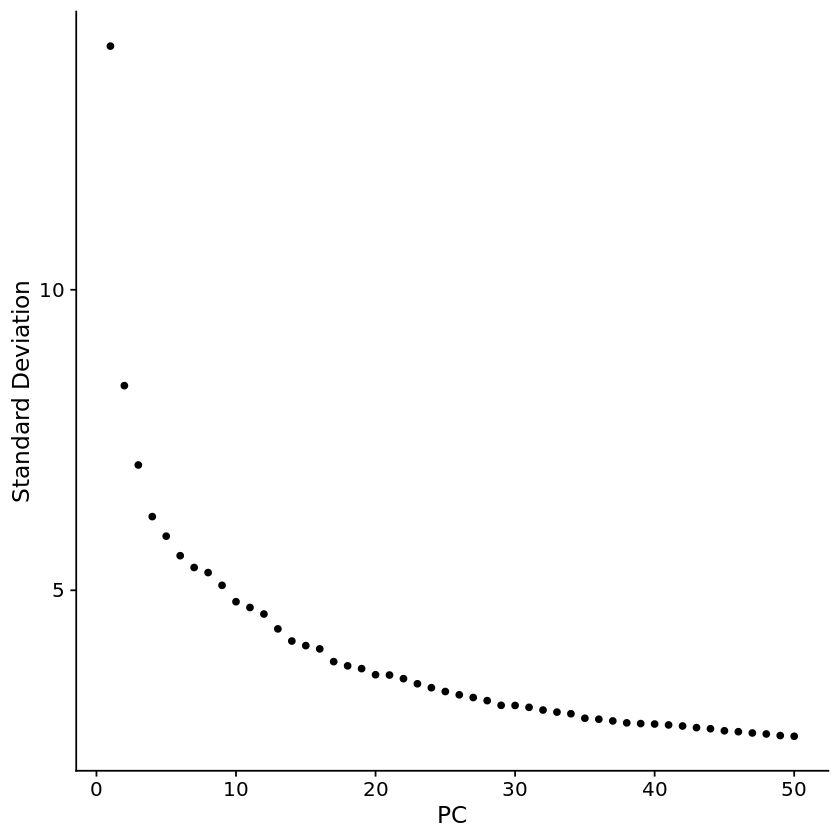

In [87]:
#run PCA analysis using variable features
seurat_78 <- RunPCA(object = seurat_78)

#Identify significant principal components
#Inclusion of principal components was based on a scree plot  by placing the cutoff at the elbow of the curve
ElbowPlot(object = seurat_78, ndims = 50)

In [94]:
#Cutoff was determined at 17 PCs
#Generate UMAP
seurat_78 <- RunUMAP(seurat_78, dims = 1:17)

15:29:27 UMAP embedding parameters a = 0.9922 b = 1.112

15:29:27 Read 4001 rows and found 17 numeric columns

15:29:27 Using Annoy for neighbor search, n_neighbors = 30

15:29:27 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

15:29:29 Writing NN index file to temp file /scratch/7478184/RtmpA4jZOT/file144962c3a43b

15:29:29 Searching Annoy index using 1 thread, search_k = 3000

15:29:30 Annoy recall = 100%

15:29:30 Commencing smooth kNN distance calibration using 1 thread

15:29:31 Initializing from normalized Laplacian + noise

15:29:31 Commencing optimization for 500 epochs, with 160626 positive edges

15:29:38 Optimization finished



Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4001
Number of edges: 141695

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9575
Number of communities: 2
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4001
Number of edges: 141695

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9332
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4001
Number of edges: 141695

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9147
Number of communities: 4
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4001
Number of edges: 141695

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8990
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer

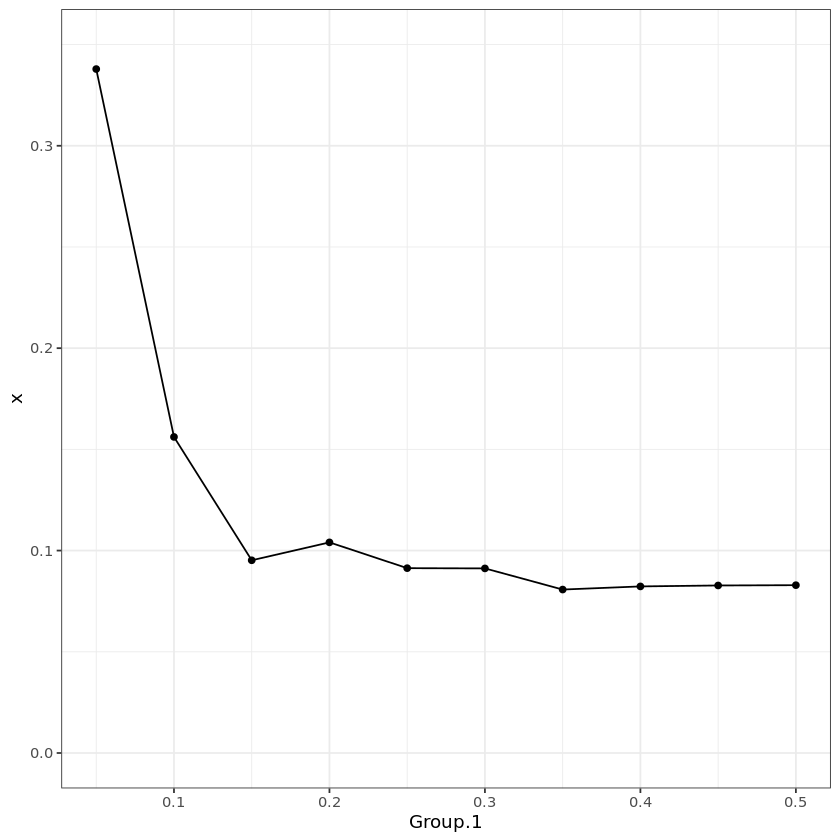

In [90]:
#For clustering of single cells, determine optimal clustering resolution by calculating average silhouette width
seurat_subset <- seurat_78

seurat_subset <- FindNeighbors(object = seurat_subset, dims = 1:17)

#generate table with silhouette widths
res_clusters <- c(0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5)
sil_width <- data.frame(res = c(), sil = c())

for(r in res_clusters){
  seurat_subset <- FindClusters(object = seurat_subset, resolution = r)
  dist.matrix <- dist(x = Embeddings(seurat_subset)[,1:17])
  clusters <- seurat_subset$seurat_clusters
  sil <- silhouette(x = as.numeric(x = as.factor(x = clusters)), dist = dist.matrix)
  seurat_subset$sil <- sil[,3]
  sil_width <- rbind(sil_width, data.frame(res = rep(r, nrow(seurat_subset@meta.data)), sil = seurat_subset$sil))
}

#calculate average silhouette width
sil_width_avg <- aggregate(sil_width$sil, by = list(sil_width$res), FUN = "mean")

#plot clustering resolution vs average silhouette width
plot_sil <- ggplot(sil_width_avg, aes(x = Group.1, y = x))+
  geom_point()+
  geom_line()+
  ylim(0,0.35)+
  theme_bw()
plot_sil

In [91]:
#Optimal clustering resolution was determined at 0.1
seurat_78 <- FindNeighbors(object = seurat_78, dims = 1:17)
seurat_78 <- FindClusters(object = seurat_78, resolution = 0.1)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 4001
Number of edges: 141695

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9332
Number of communities: 3
Elapsed time: 0 seconds


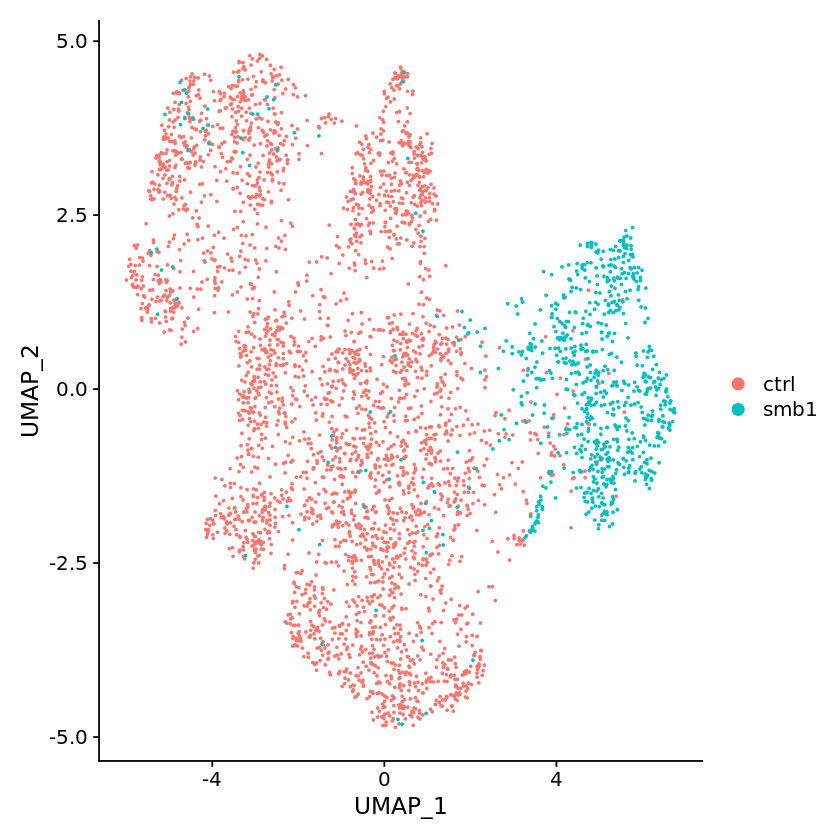

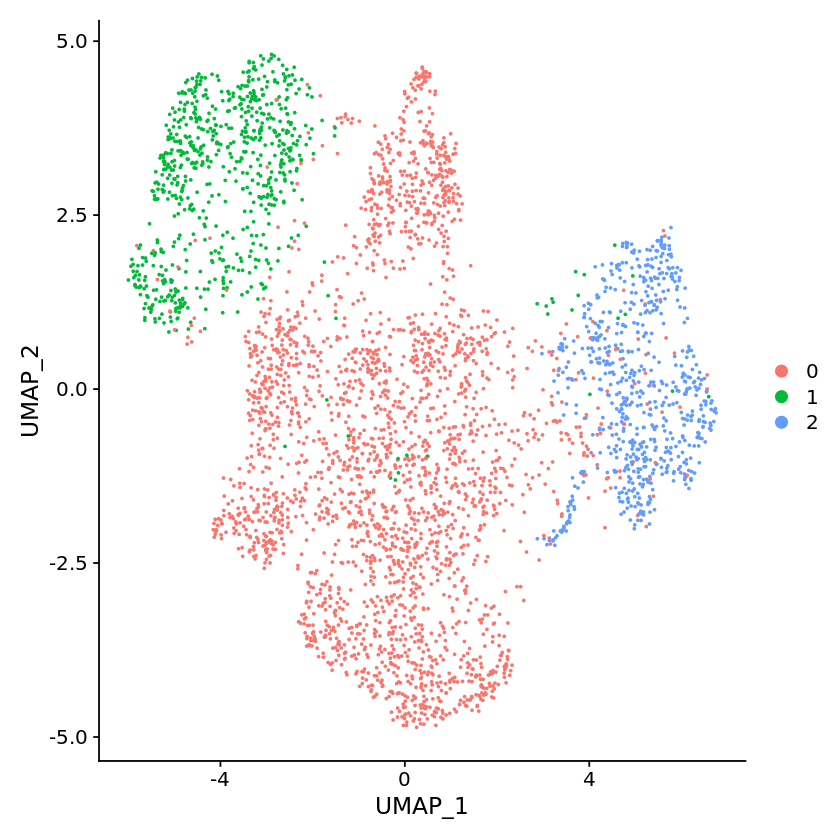

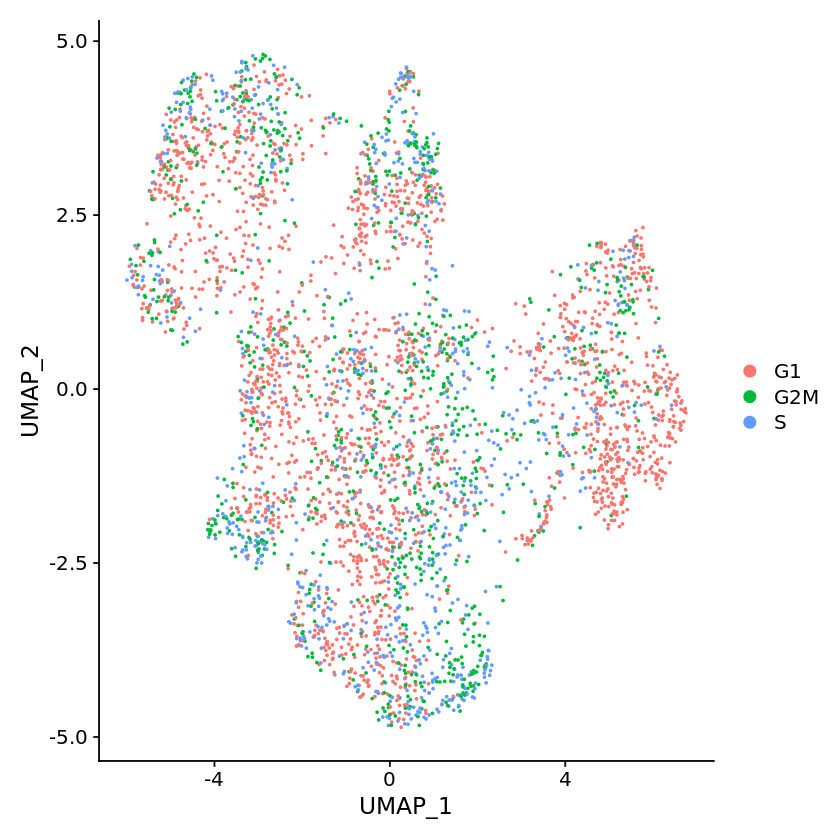

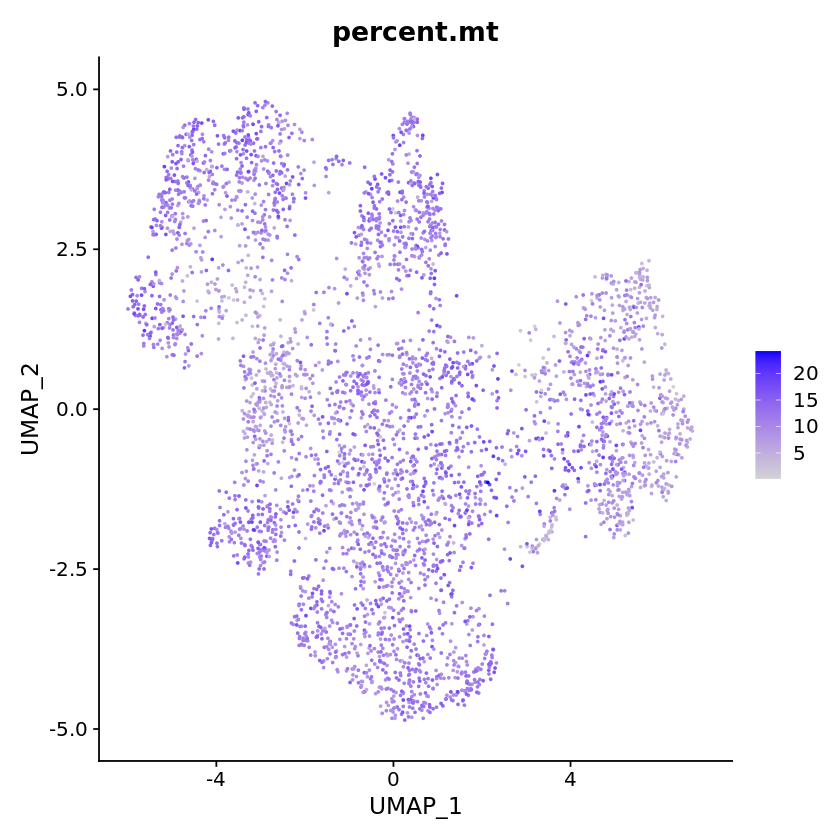

In [95]:
#Plot umaps, to show seperation of cells, grouped by smarcb1 and clusters
DimPlot(seurat_78, reduction = "umap", group.by = "smarcb1")
DimPlot(seurat_78, reduction = "umap", group.by = "seurat_clusters")

#QC: plot umaps, to show seperation of cells, grouped by cell cycle phase and mitrochondrial percentage
DimPlot(seurat_78, reduction = "umap", group.by = "Phase")
FeaturePlot(seurat_78, reduction = "umap", features = "percent.mt")

In [96]:
#Generate module scores for each cell
#Module scores are generated by averaging gene expression levels per set of genes
seurat_78 <- AddModuleScore(seurat_78, features = list(me_aut_genes_early), name = "aut_mes_early")
seurat_78 <- AddModuleScore(seurat_78, features = list(me_aut_genes_late), name = "aut_mes_late")
seurat_78 <- AddModuleScore(seurat_78, features = list(sen_genes_early), name = "sen_early")
seurat_78 <- AddModuleScore(seurat_78, features = list(sen_genes_late), name = "sen_late")

Warning message:
“The following features are not present in the object: NIBAN2, GFRA2, ITGA4, MPZ, RHOJ, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: ANGPTL1, ARAP3, ASCL1, CCL15-CCL14, CCL23, CDH19, LIMCH1, NDST3, PHOX2B, SNTB1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: AC008012.1, AC020907.6, HEYL, HOXB8, NEUROG2, NKX1-2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: CHRNB4, AC090227.2, NEUROD4, NEUROG1, NHLH2, ONECUT1, PCDH8, PPP1R17, SRRM4, TAGLN3, AC092143.1, not searching for symbol synonyms”


# Seperate analysis for each patient line: 103T

In [97]:
#calculate percentage of mitochondrial genes to use for normalization
seurat_103[["percent.mt"]] <- PercentageFeatureSet(object = seurat_103, pattern = "^MT-")

#normalize and regress out percentage of mitochondrial genes
#suppress warning: iteration limit reached
seurat_103 <- suppressWarnings(SCTransform(seurat_103, vars.to.regress = c("percent.mt"), return.only.var.genes = FALSE))

#determine cell cycle phase
s.genes <- cc.genes$s.genes
g2m.genes <- cc.genes$g2m.genes
seurat_103 <- CellCycleScoring(object = seurat_103, s.features = s.genes, g2m.features = g2m.genes)

#renormalize to regress out cell cycle effects
#suppress warning: iteration limit reached
seurat_103 <- suppressWarnings(SCTransform(seurat_103, vars.to.regress = c("percent.mt", "S.Score", "G2M.Score"), return.only.var.genes = FALSE))

Calculating cell attributes for input UMI matrix

Variance stabilizing transformation of count matrix of size 18614 by 3647

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3647 cells



  |======================================================================| 100%


Found 3 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18614 genes



  |======================================================================| 100%


Computing corrected count matrix for 18614 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.791724 mins

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Regressing out percent.mt

Centering data matrix

Set default assay to SCT

Warning message:
“The following features are not present in the object: MLF1IP, not searching for symbol synonyms”
Calculating cell attributes for input UMI matrix

Variance stabilizing transformation of count matrix of size 18614 by 3647

Model formula is y ~ log_umi

Get Negative Binomial regression parameters per gene

Using 2000 genes, 3647 cells



  |======================================================================| 100%


Found 3 outliers - those will be ignored in fitting/regularization step


Second step: Get residuals using fitted parameters for 18614 genes



  |======================================================================| 100%


Computing corrected count matrix for 18614 genes



  |======================================================================| 100%


Calculating gene attributes

Wall clock passed: Time difference of 1.790022 mins

Determine variable features

Set 3000 variable features

Place corrected count matrix in counts slot

Regressing out percent.mt, S.Score, G2M.Score

Centering data matrix

Set default assay to SCT



PC_ 1 
Positive:  TMSB4X, SFRP1, TIMP3, PRRX1, S100A6, S100A4, GAS7, FAM9C, FGF5, SMPX 
	   PPP1R14A, S100A16, CTSL, PHLDA1, CAMK2N1, L1TD1, PRG4, PPA1, COL6A1, SEMA3A 
	   PRDM8, SVIP, ZNF185, TM4SF1, SMS, PRSS23, HMCN1, FGFR1, EFNB2, CALM1 
Negative:  MGP, RPS12, RPL27A, BTG1, H2AFJ, LGALS3, IMPA2, TRIML2, RPS4X, PEG3 
	   COL1A2, RPS2, FTL, MSX1, FGF7, RPS20, RPL13A, PFDN5, SYT1, PLAT 
	   MAP9, EML4, RPSA, RPL3, ID4, RERG, NPM1, CCND2, MEIS2, NDP 
PC_ 2 
Positive:  MGP, VIM, LGALS3, RPL27A, PPA1, RPS12, CSTB, RPS4X, ARHGAP15, TAGLN 
	   RPS2, RPL3, IGFL3, RPL13A, TWISTNB, SMS, PRRX1, HINT1, RPSA, GAPDH 
	   SMPX, NPM1, RPL10, FGF5, FAM9C, NME1, HSP90AB1, CTSL, GAS7, PFDN5 
Negative:  IGFN1, SERPINE2, DST, NEAT1, MEG3, COL1A1, MALAT1, IGFBP5, APOE, SMARCB1 
	   COL1A2, FBN1, CTSB, SLC4A7, MMP2, DAB2, LINC01021, CPA4, THBS2, AL589743.1 
	   AEBP1, RALGPS2, PXDN, KRT17, MDM2, ITGB1, PEG10, CD44, UACA, EMILIN2 
PC_ 3 
Positive:  SYT1, LGALS3, MARCKS, SOST, SMS, RNF19A, TLE4, DST, NRP2,

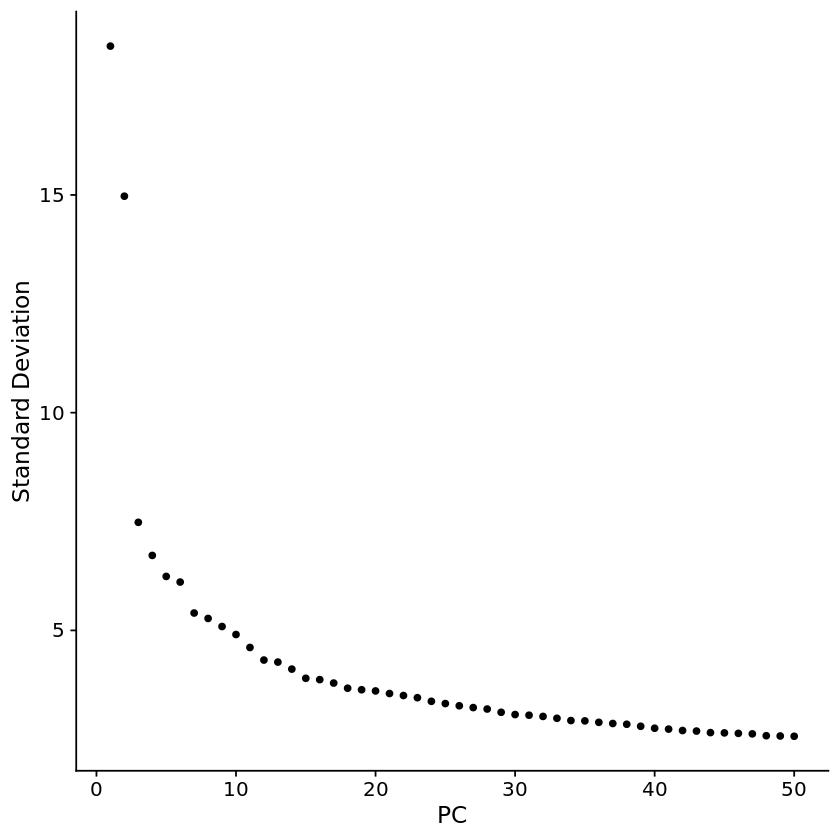

In [98]:
#run PCA analysis using variable features
seurat_103 <- RunPCA(object = seurat_103)

#Identify significant principal components
#Inclusion of principal components was based on a scree plot  by placing the cutoff at the elbow of the curve
ElbowPlot(object = seurat_103, ndims = 50)

In [99]:
#Cutoff was determined at 15 PCs
#Generate UMAP
seurat_103 <- RunUMAP(seurat_103, dims = 1:15)

15:37:12 UMAP embedding parameters a = 0.9922 b = 1.112

15:37:12 Read 3647 rows and found 15 numeric columns

15:37:12 Using Annoy for neighbor search, n_neighbors = 30

15:37:12 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*

|

15:37:13 Writing NN index file to temp file /scratch/7478184/RtmpA4jZOT/file14493f9e2e88

15:37:13 Searching Annoy index using 1 thread, search_k = 3000

15:37:15 Annoy recall = 100%

15:37:15 Commencing smooth kNN distance calibration using 1 thread

15:37:16 Initializing from normalized Laplacian + noise

15:37:16 Commencing optimization for 500 epochs, with 146654 positive edges

15:37:22 Optimization finished



Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3647
Number of edges: 122718

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9681
Number of communities: 3
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3647
Number of edges: 122718

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9488
Number of communities: 5
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3647
Number of edges: 122718

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9356
Number of communities: 6
Elapsed time: 0 seconds
Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3647
Number of edges: 122718

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9233
Number of communities: 7
Elapsed time: 0 seconds
Modularity Optimizer

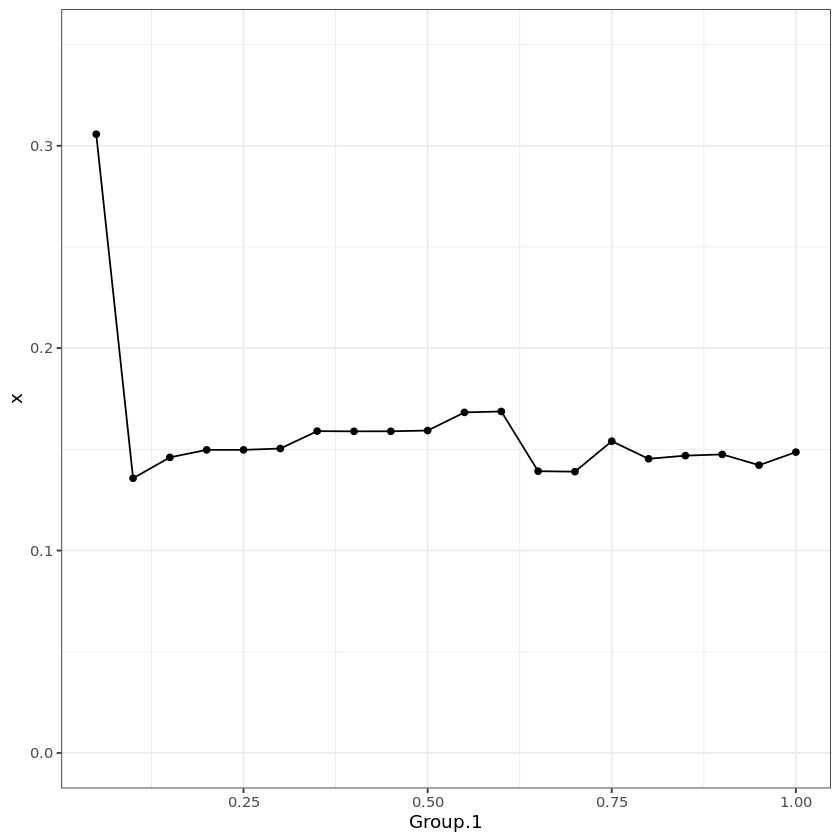

In [100]:
#For clustering of single cells, determine optimal clustering resolution by calculating average silhouette width
seurat_subset <- seurat_103

seurat_subset <- FindNeighbors(object = seurat_subset, dims = 1:15)

#generate table with silhouette widths
res_clusters <- c(0.05,0.1,0.15,0.2,0.25,0.3,0.35,0.4,0.45,0.5,0.55,0.6,0.65,0.7,0.75,0.8,0.85,0.9,0.95,1)
sil_width <- data.frame(res = c(), sil = c())

for(r in res_clusters){
  seurat_subset <- FindClusters(object = seurat_subset, resolution = r)
  dist.matrix <- dist(x = Embeddings(seurat_subset)[,1:15])
  clusters <- seurat_subset$seurat_clusters
  sil <- silhouette(x = as.numeric(x = as.factor(x = clusters)), dist = dist.matrix)
  seurat_subset$sil <- sil[,3]
  sil_width <- rbind(sil_width, data.frame(res = rep(r, nrow(seurat_subset@meta.data)), sil = seurat_subset$sil))
}

#calculate average silhouette width
sil_width_avg <- aggregate(sil_width$sil, by = list(sil_width$res), FUN = "mean")

#plot clustering resolution vs average silhouette width
plot_sil <- ggplot(sil_width_avg, aes(x = Group.1, y = x))+
  geom_point()+
  geom_line()+
  ylim(0,0.35)+
  theme_bw()
plot_sil

In [101]:
#Optimal clustering resolution was determined at 0.55
seurat_103 <- FindNeighbors(object = seurat_103, dims = 1:15)
seurat_103 <- FindClusters(object = seurat_103, resolution = 0.55)

Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 3647
Number of edges: 122718

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8633
Number of communities: 10
Elapsed time: 0 seconds


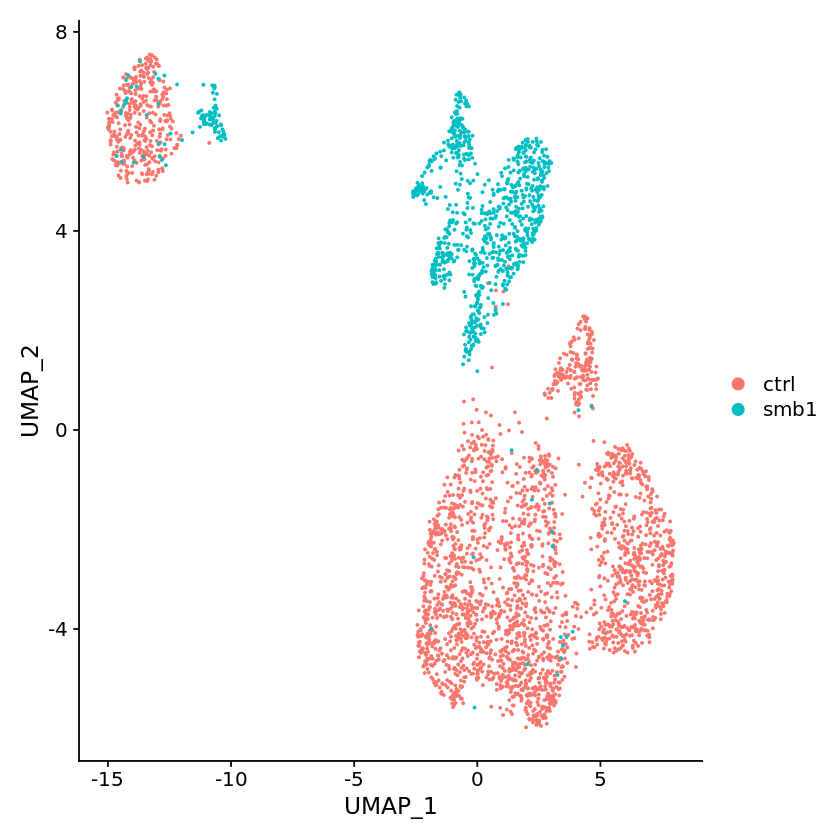

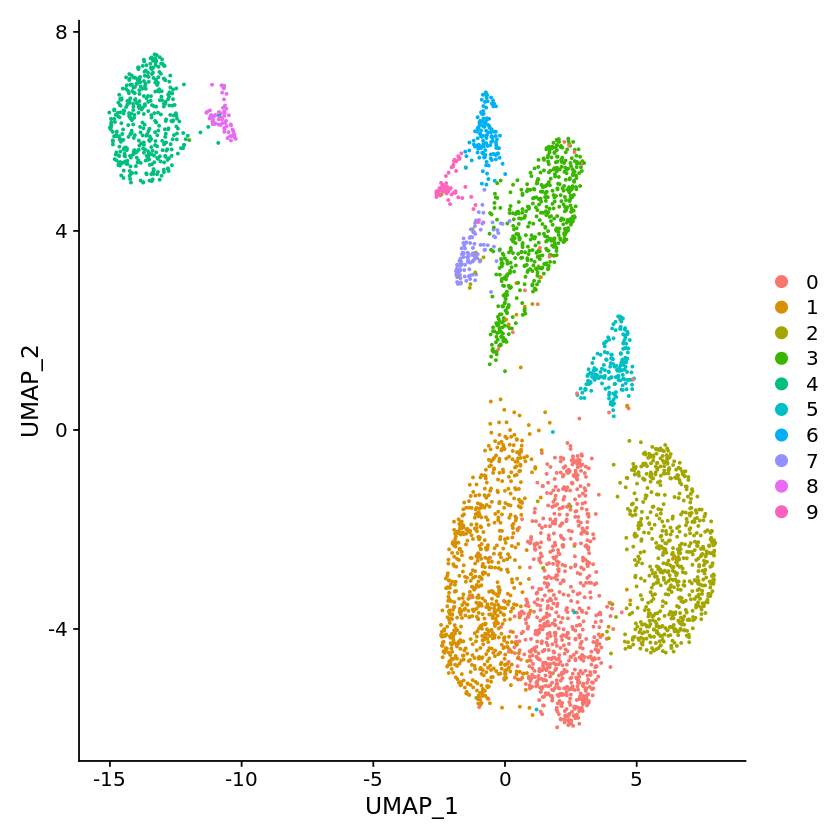

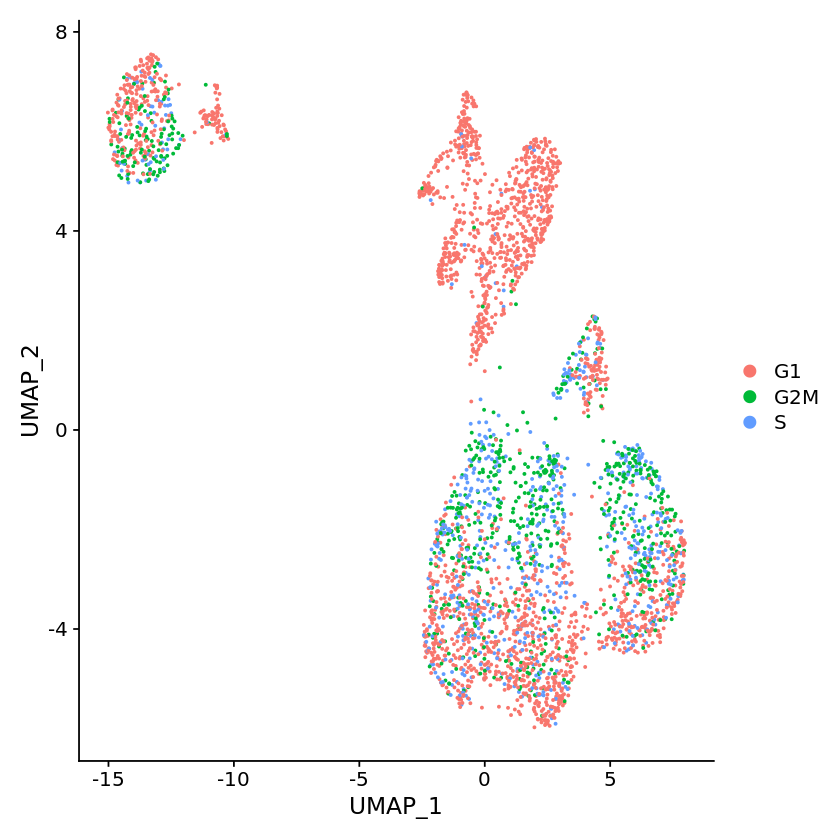

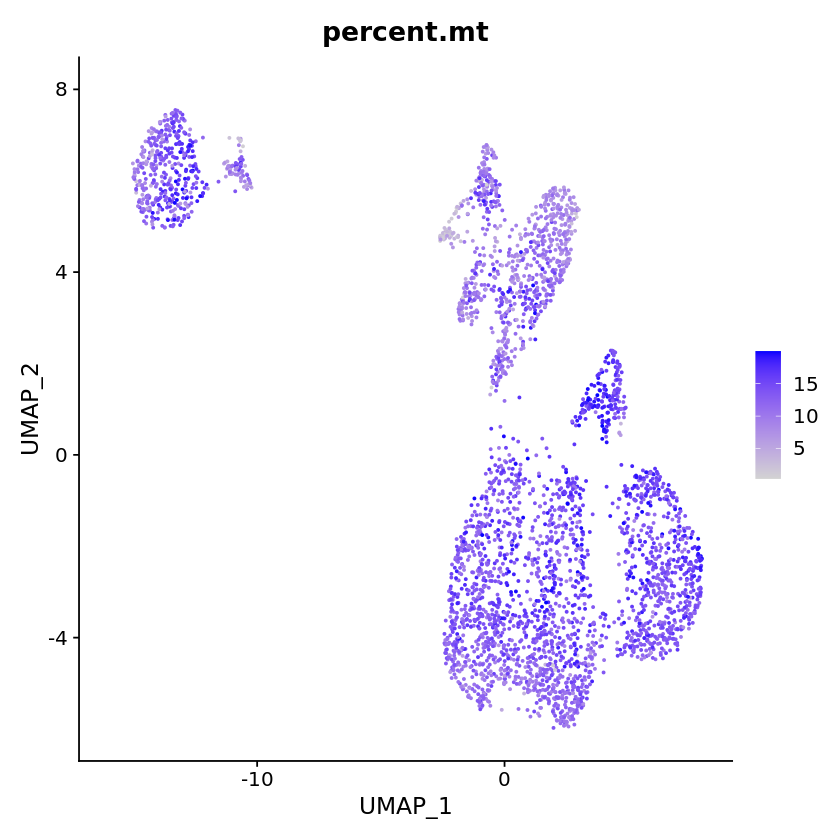

In [102]:
#Plot umaps, to show seperation of cells, grouped by smarcb1 and clusters
DimPlot(seurat_103, reduction = "umap", group.by = "smarcb1")
DimPlot(seurat_103, reduction = "umap", group.by = "seurat_clusters")

#QC: plot umaps, to show seperation of cells, grouped by cell cycle phase and mitrochondrial percentage
DimPlot(seurat_103, reduction = "umap", group.by = "Phase")
FeaturePlot(seurat_103, reduction = "umap", features = "percent.mt")

In [103]:
#Generate module scores for each cell
#Module scores are generated by averaging gene expression levels per set of genes
seurat_103 <- AddModuleScore(seurat_103, features = list(me_aut_genes_early), name = "aut_mes_early")
seurat_103 <- AddModuleScore(seurat_103, features = list(me_aut_genes_late), name = "aut_mes_late")
seurat_103 <- AddModuleScore(seurat_103, features = list(sen_genes_early), name = "sen_early")
seurat_103 <- AddModuleScore(seurat_103, features = list(sen_genes_late), name = "sen_late")

Warning message:
“The following features are not present in the object: NIBAN2, RAI2, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: ASCL1, CCL15-CCL14, CCL15, CCL23, CDH19, MME, NDST3, PHOX2B, SNTB1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: AC008012.1, ELAVL4, AC020907.6, HOXB8, LEF1, NKX1-2, POU4F1, not searching for symbol synonyms”
Warning message:
“The following features are not present in the object: EYA2, HES5, AC090227.2, NEUROD1, NEUROD4, NEUROG1, NHLH2, ONECUT1, PPP1R17, SRRM4, AC092143.1, not searching for symbol synonyms”
